In [1]:
import os
import random
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
from PIL import Image
from plotly import tools
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
PATH = 'F:/herbarium-2020_data/nybg2020/train/'
OPEN_DIR = os.listdir(PATH)
DIR_TRAIN = PATH+OPEN_DIR[0]
META_DATA = PATH+OPEN_DIR[1]

In [3]:
with open(META_DATA, 'r') as json_file:
    data = json.load(json_file)
    for key in data:
        print("-",key, len(data[key]))

- annotations 1030747
- categories 32094
- images 1030747
- info 6
- licenses 1
- regions 4


In [4]:
df_images = pd.DataFrame(data['images'])
df_categories = pd.DataFrame(data['categories'])
df_annotations = pd.DataFrame(data['annotations'])

In [5]:
df_images.head(3)

file_name  height      id  license  width
0  images/156/72/354106.jpg    1000  354106        1    661
1  images/115/24/818566.jpg    1000  818566        1    661
2  images/115/24/750704.jpg    1000  750704        1    661

In [6]:
df_annotations.head(3)

category_id      id  image_id  region_id
0        15672  354106    354106          1
1        11524  818566    818566          1
2        11524  750704    750704          1

In [7]:
assert len(df_annotations) == len(df_images)
df_images_annotations = pd.merge(df_images, df_annotations, left_on='id', right_on='image_id', how='right').drop('image_id', axis=1)
df_images_annotations = df_images_annotations.sort_values(['category_id'])

In [8]:
df_images_annotations.head(4)

file_name  height    id_x  license  width  category_id  \
76407   images/000/00/626762.jpg    1000  626762        1    681            0   
601590   images/000/00/72077.jpg    1000   72077        1    681            0   
76408   images/000/00/818271.jpg    1000  818271        1    681            0   
556748  images/000/00/495523.jpg    1000  495523        1    681            0   

          id_y  region_id  
76407   626762          1  
601590   72077          1  
76408   818271          1  
556748  495523          1

In [9]:
df_images_annotations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030747 entries, 76407 to 479781
Data columns (total 8 columns):
file_name      1030747 non-null object
height         1030747 non-null int64
id_x           1030747 non-null int64
license        1030747 non-null int64
width          1030747 non-null int64
category_id    1030747 non-null int64
id_y           1030747 non-null int64
region_id      1030747 non-null int64
dtypes: int64(7), object(1)
memory usage: 70.8+ MB


## ======= Count sample per category ========

In [10]:
groups = df_images_annotations.groupby('category_id')
dict_infos = []
for i in range(len(groups)):
#     print('Category = %s | Count samples per category = %s' % (groups.get_group(i).set_index('file_name')['category_id'][0], len(groups.get_group(i).set_index('file_name'))))
    if i != 23079:
        dic = {'category':groups.get_group(i).set_index('file_name')['category_id'][0], 'nb_samples':len(groups.get_group(i).set_index('file_name'))}
        dict_infos.append(dic)

In [11]:
# df_infos = pd.DataFrame(dict_infos, index=None)
# df_infos.to_csv('C:/Users/hamza/HerbariumKaggle/sample_per_category.csv',index=False, sep=';')

## =============== End ===============

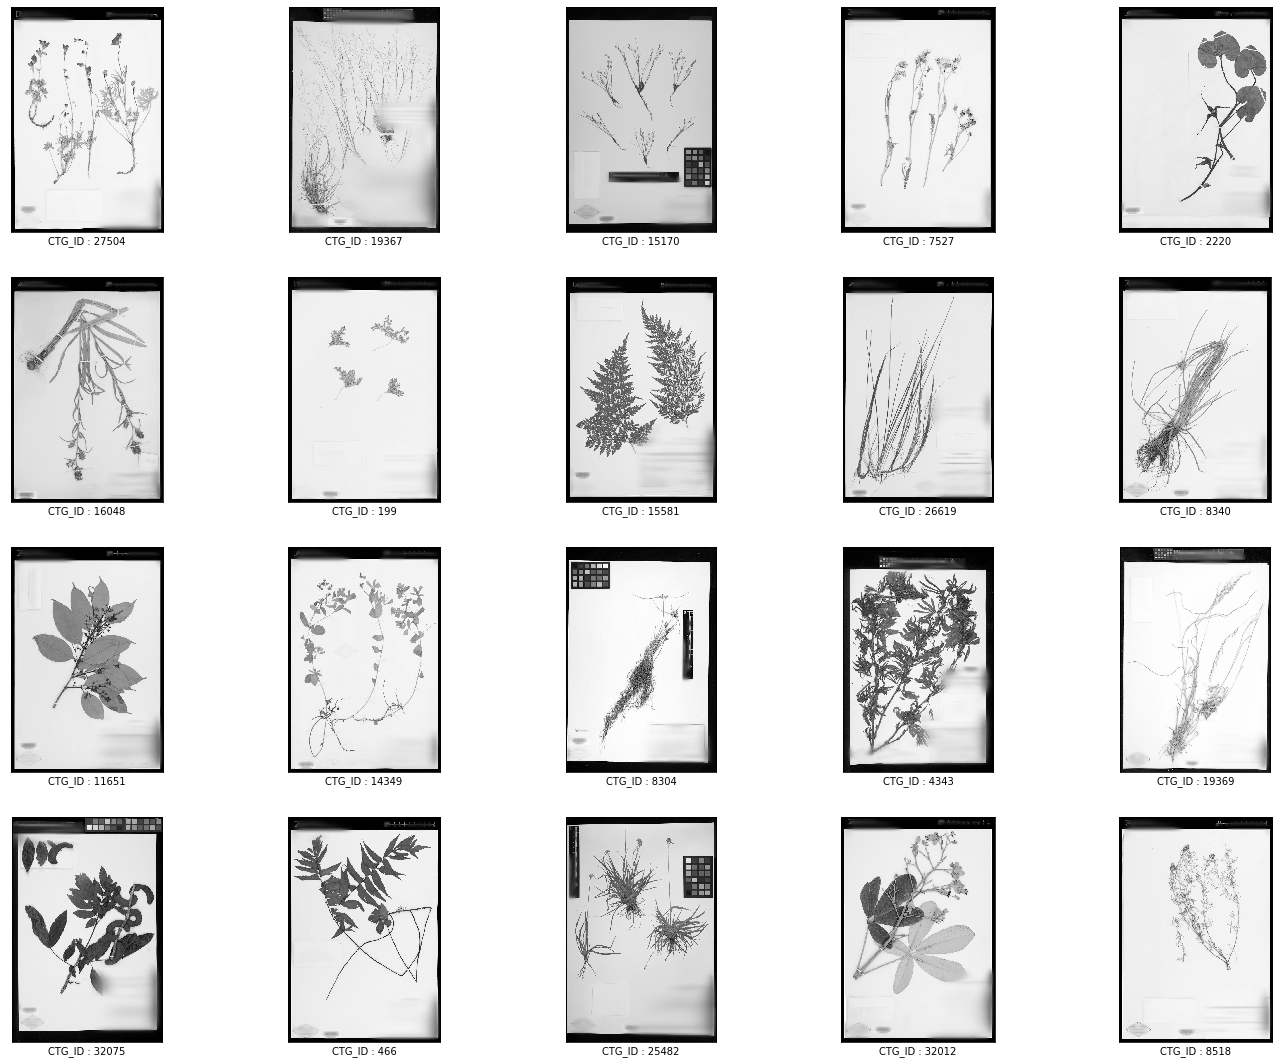

In [12]:
def plot_samples(df, size=(22,22), nb_samples=20, cmap=False):
    
    plt.figure(figsize=size)
    for i in range(nb_samples):
        random_sample = df.iloc[np.random.random_integers(i,len(df) - 1)]
        
        if cmap:
            random_sample_img = Image.open(PATH+random_sample['file_name']).convert("L")
        else:
            random_sample_img = mpimg.imread(PATH+random_sample['file_name'])
            
        arr = np.asarray(random_sample_img)
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        if cmap:
            plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(random_sample_img, cmap=plt.cm.binary)
            
        plt.xlabel("CTG_ID : "+str(random_sample['category_id']))
    plt.show()
    
plot_samples(df_images_annotations, size=(24,24), nb_samples=20, cmap="gray")

In [13]:
df_sampels = df_images_annotations[['file_name', 'category_id']]
# df_sampels.to_csv('sample.csv' , index=False, sep=";")
df_sampels.head(4)

file_name  category_id
76407   images/000/00/626762.jpg            0
601590   images/000/00/72077.jpg            0
76408   images/000/00/818271.jpg            0
556748  images/000/00/495523.jpg            0

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(list(df_sampels.file_name[0:4000]), list(df_sampels.category_id[0:4000]), test_size = 0.1, random_state = 0)

In [15]:
len(x_train),len(x_test)

(3600, 400)

In [16]:
x_train[0], y_train[0]

('images/000/31/627976.jpg', 31)

## ======================= MODEL START =======================

In [17]:
def read_images(x, y, resize_to=(128, 128)):
    
    images = []
    labels = []    
    
    for i, image in enumerate(x):
        
        im = Image.open(PATH+image)
        im = im.resize(resize_to)
        im = np.array(im) / 255.0
        im = im.astype("float32")
        images.append(im)
       
        labels.append(y[i])
    
    
    return np.array(images), np.array(labels)

x_train, y_train = read_images(x_train, y_train, resize_to=(64, 64))
x_test, y_test = read_images(x_test, y_test, resize_to=(64, 64))

print("\t- NB TRAIN SAMPLES %s WIDTH %s HEIGHT %s COLOR %s" % (x_train.shape))
print("\t- NB TEST SAMPLES %s WIDTH %s HEIGHT %s COLOR %s" % (x_test.shape))

	- NB TRAIN SAMPLES 3600 WIDTH 64 HEIGHT 64 COLOR 3
	- NB TEST SAMPLES 400 WIDTH 64 HEIGHT 64 COLOR 3


In [18]:
def one_hote_encoding(y_train, y_test):
    
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    
    return y_train, y_test

y_train, y_test = one_hote_encoding(y_train, y_test)

In [19]:
def hyperParams():
        
    modelParams = {"Layers":[
#                     {"neurons":1 , "activation":"tanh", "dropOut":False},
                    {"neurons":151, "activation":"softmax", "dropOut":False}
                    ],
                   "loss":"categorical_crossentropy",
                   "optimizer":"SGD(lr=0.001)",
                   "metrics":"accuracy",
                   "learningRate":.001,
                   "epochs":120,
                   "batchSize":50,
                   "testName":"Simple Linear Model"
                 }
    return modelParams

In [20]:
def createModel(params):
    
    model = Sequential()
    model.add(Flatten(input_shape=(64,64,3)))
    for layers in params['Layers']:
        if layers['dropOut'] == False:
            model.add(Dense(layers['neurons'], activation=layers['activation']))
        else:
            model.add(Dense(layers['neurons'], activation=layers['activation']))
            model.add(Dropout(layers['dropOut']))
    
    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    model.compile(loss=params['loss'],
                   optimizer=opt,
                   metrics=['accuracy'])
    
    model.summary()
    return model

In [21]:
def reshapeInput(x_train, x_test):
    
    x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3]) #
    x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3]) #
    
    return x_train, x_test

x_train, x_train = reshapeInput(x_train, x_train)

In [22]:
def fitModel(model, params, x_train, y_train, x_test, y_test):
    
#     start_time = time.time()
#     tensorboard = TensorBoard(log_dir='D:\logsProject\{}'.format(logName()))
    ################################ CALCULATE RUNTIME - START ###############################
    history = model.fit(x_train, y_train,
                       epochs=params['epochs'],
                       batch_size=params['batchSize'], verbose=1, validation_data=(x_test, y_test))
    ################################ CALCULATE RUNTIME - END ###############################

    return model, history

In [23]:
def evaluateModel(model, x_test, y_test):
    
    return model.evaluate(x_test, y_test, batch_size=50)

In [24]:
def predictionPercent(model, x_test, y_test):
    
    prediction = model.predict(x_test)
    predicted = []
    for i in range(len(prediction)):
        if np.argmax(y_test[i]) == np.argmax(prediction[i]):
            predicted.append(1)
        else:
            predicted.append(0)
    print("Predicted percent {} %".format((sum(predicted)/(len(predicted)) * 100)))
    result = (sum(predicted)/len(predicted)) * 100
    
    return prediction, result

In [25]:
def plotPredictedResult(prediction, x_test, y_test):
    
    plt.figure(figsize=(15, 15))
    for i in range(20):
        plt.subplot(5,7,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_test[i])
        plt.xlabel("True: "+str(np.argmax(y_test[i]))+"\n\n\n")
        plt.title("\nPredicted: "+str(np.argmax(prediction[i])))
        
    plt.show()

In [26]:
def trace(x,y,imagesLabels,color):
        trace = go.Scatter(
            x = x,y = y,
            name=imagesLabels,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plotAccLoss(model):
    
    hist = model.history
    acc = hist['accuracy']
    valAcc = hist['val_accuracy']
    loss = hist['loss']
    valLoss = hist['val_loss']

    epochs = list(range(1,len(acc)+1))

    traceA = trace(epochs,acc,"Training accuracy", "Green")
    traceVa = trace(epochs,valAcc,"Validation accuracy", "Red")
    traceL = trace(epochs,loss,"Training loss", "Blue")
    traceVl = trace(epochs,valLoss,"Validation loss", "Magenta")

    fig = plotly.subplots.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(traceA,1,1)
    fig.append_trace(traceVa,1,1)
    fig.append_trace(traceL,1,2)
    fig.append_trace(traceVl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])


    iplot(fig, filename='accuracy-loss')

================================ GENERATE PARAMS ================================
================================ CREATE MODEL ================================
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 151)               1855639   
Total params: 1,855,639
Trainable params: 1,855,639
Non-trainable params: 0
_________________________________________________________________
================================ RESHAPE INPUTS ================================
================================ FIT MODEL ================================
Train on 3600 samples, validate on 400 samples
Epoch 1/120
3600/3600 [==============================] - 2s 498us/sample - loss: 270.2864 - accuracy: 0.0386 - val_loss: 290.2172 - val_accurac

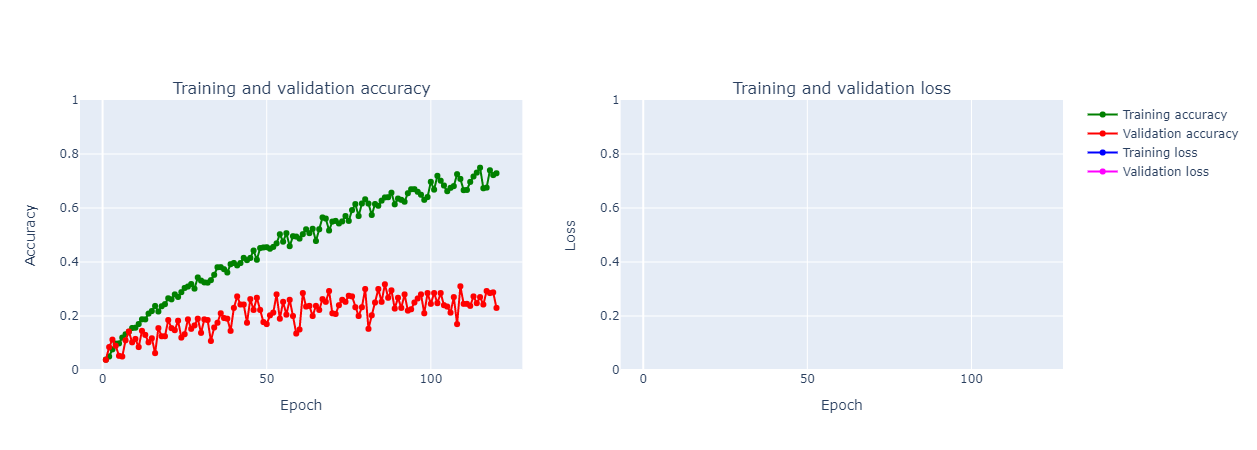

================================ EVALUATE MODEL ================================
400/400 [==============================] - 0s 166us/sample - loss: 27.3187 - accuracy: 0.2300
================================ PREDICITION ================================
Predicted percent 23.0 %
================================ PLOT PREDICITION ================================


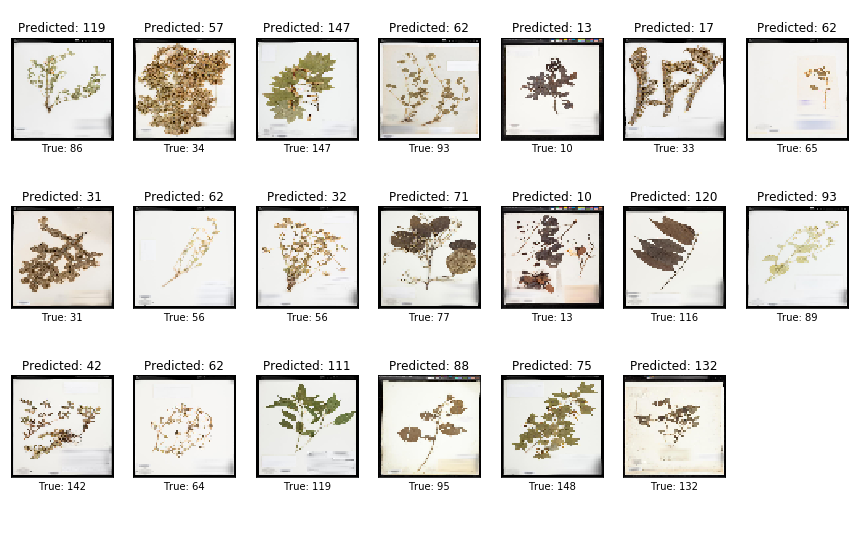

In [27]:
global ID
ID = random.randint(1,1000000)
    
print("================================ GENERATE PARAMS ================================")
params = hyperParams()

print("================================ CREATE MODEL ================================")
model = createModel(params)

plot_model(model, "model_"+str(ID)+"_.png")

print("================================ RESHAPE INPUTS ================================")
x_train, x_test = reshapeInput(x_train, x_test)

print("================================ FIT MODEL ================================")
model, history = fitModel(model, params, x_train, y_train, x_test, y_test)

print("================================ PLOT ACCURACY AND LOSS ================================")
plotAccLoss(history)

print("================================ EVALUATE MODEL ================================")
resultEV = evaluateModel(model, x_test, y_test)

print("================================ PREDICITION ================================")
prediction, result = predictionPercent(model, x_test, y_test)

print("================================ PLOT PREDICITION ================================")
plotPredictedResult(prediction, x_test, y_test)